In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import menpo
import menpo.io as mio
import menpo3d
from menpo.shape import mean_pointcloud, PointCloud, TriMesh
from menpofit.modelinstance import OrthoPDM, PCAModel
from menpowidgets import visualize_images
from menpo.io import export_image, export_landmark_file
from menpowidgets import visualize_appearance_model

In [8]:
import readline
import rpy2
import rpy2.robjects as robjects
r = robjects.r

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [2]:
unfam_df = pd.read_csv("/data1/famface01/analysis/encoding/12_Features/unfam_final_frame_df.csv")
unfam_df.head()

,Unnamed: 0,vnum,vid,frame,category,fpath
0,0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
1,1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
2,2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
3,3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
4,4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...


In [3]:
ref_vids = sorted(np.unique(unfam_df.vid))

In [4]:
vidnames = sorted(os.listdir("/data1/famface01/data/stimuli/vids/eight_frames/three_dee"))
print len(vidnames)
vidnames = [ v for v in vidnames if v in ref_vids ]
print len(vidnames)

1248
864


In [5]:
basedir = "/data1/famface01/data/stimuli/vids/eight_frames/three_dee"

blend_mats = []
shape_mats = []
pose_mats  = []

for v in tqdm(vidnames):
    blend = np.loadtxt(os.path.join(basedir, v, "%s_coefs_blend.txt" % v))
    shape = np.loadtxt(os.path.join(basedir, v, "%s_coefs_shape.txt" % v))
    pose  = np.loadtxt(os.path.join(basedir, v, "%s_pose.txt" % v))
    blend_mats.append(blend)
    shape_mats.append(shape)
    pose_mats.append(pose)

blend_mats = np.array(blend_mats)
shape_mats = np.array(shape_mats)
pose_mats  = np.array(pose_mats)

print blend_mats.shape
print shape_mats.shape
print pose_mats.shape

100%|██████████| 864/864 [00:17<00:00, 48.72it/s]

(864, 8, 6)
(864, 8, 63)
(864, 8, 3)


In [19]:
mean_shape_framediff = []
mean_blend_framediff = []
mean_pose_framediff  = []

n = len(vidnames)
for i in tqdm(range(n)):
    ds1 = []; ds2 = []; ds3 = []
    for j in range(7):
        d1 = np.sqrt(np.sum((shape_mats[i,j,:] - shape_mats[i,j+1,:])**2))
        d2 = np.sqrt(np.sum((blend_mats[i,j,:] - blend_mats[i,j+1,:])**2))
        d3 = np.sqrt(np.sum((pose_mats[i,j,:] - pose_mats[i,j+1,:])**2))
        ds1.append(d1)
        ds2.append(d2)
        ds3.append(d3)
    mean_shape_framediff.append(np.mean(ds1))
    mean_blend_framediff.append(np.mean(ds2))
    mean_pose_framediff.append(np.mean(ds3))

mean_shape_framediff = np.array(mean_shape_framediff)
mean_blend_framediff = np.array(mean_blend_framediff)
mean_pose_framediff  = np.array(mean_pose_framediff)

100%|██████████| 864/864 [00:00<00:00, 4379.05it/s]


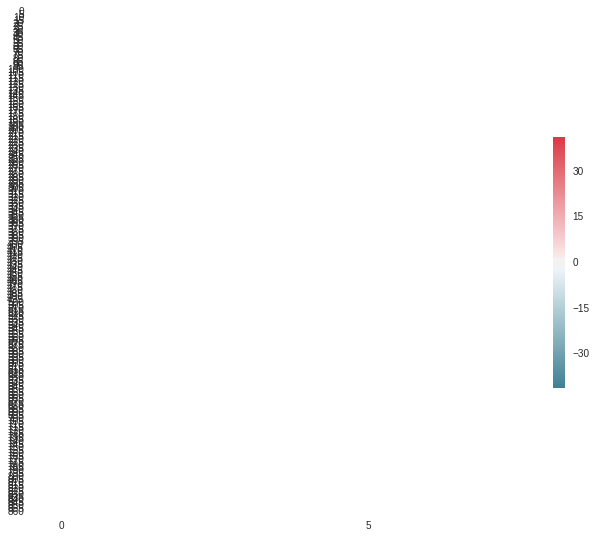

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pose_mats[:,:,0], cmap=cmap, vmax=.3,
            square=False, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

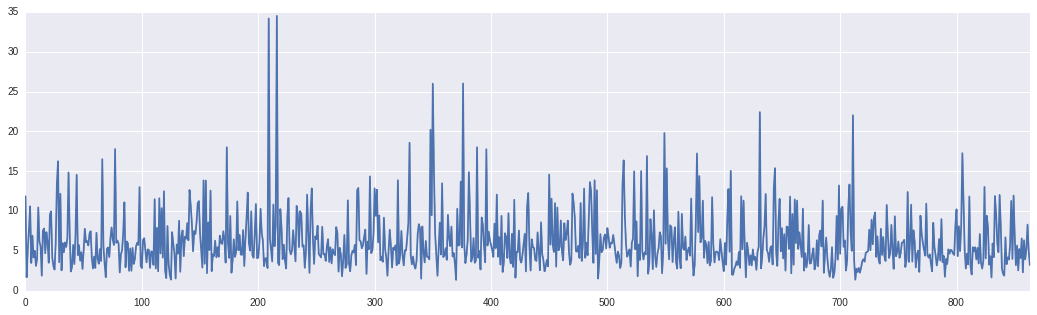

In [32]:
plt.figure(figsize=(18,5))
sns.tsplot(mean_pose_framediff)

In [45]:
# most pose change
print np.array(vidnames)[mean_pose_framediff.argsort()[::-1]][:10]
# least pose change
print np.array(vidnames)[mean_pose_framediff.argsort()[::1]][:10]

['Erin_Cummings_U163_vid03_clip11_2secs' 'Eric_Staal_vid01_clip05_2secs'
 'Joanna_Garc__a_vid01_clip05_2secs' 'Jan_Ullrich_vid02_clip04_2secs'
 'Ticiane_Pinheiro' 'vid10_face05_2s' 'James_Napier_Robertson'
 'Peri_Gilpin_vid05_clip01_2secs' 'JC_Chasez_vid02_clip04_2secs'
 'Jukka_Poika']
['Jeri_Ryan_vid04_clip09_2secs' 'vid12_face01_2s'
 'Darcy_Regier_vid04_clip01_2secs' 'Jacques_Chirac_U088_vid06_clip11_2secs'
 'Mary_Crosby_U228_vid04_clip09_2secs'
 'Dave_McGinnis_U011_vid02_clip02_2secs' 'Cyprien'
 'manyfaces01_vid03_clip05_face17_2secs' 'Lara_Logan_vid02_clip04_2secs'
 'wall_of_faces_vid58']


In [46]:
# most pose change
print np.array(mean_pose_framediff)[mean_pose_framediff.argsort()[::-1]][:10]
# least pose change
print np.array(mean_pose_framediff)[mean_pose_framediff.argsort()[::1]][:10]

[ 34.48225375  34.1586883   26.00951935  25.97885987  22.41254401
  22.02079546  20.20239273  19.79539939  18.57348493  18.00793857]
[ 1.37352008  1.39696683  1.40205509  1.52621285  1.53507425  1.54534835
  1.59288834  1.63145592  1.64910108  1.67274017]


In [47]:
# most pose change
print np.array(vidnames)[mean_pose_framediff.argsort()[::-1]][:20]

['Erin_Cummings_U163_vid03_clip11_2secs' 'Eric_Staal_vid01_clip05_2secs'
 'Joanna_Garc__a_vid01_clip05_2secs' 'Jan_Ullrich_vid02_clip04_2secs'
 'Ticiane_Pinheiro' 'vid10_face05_2s' 'James_Napier_Robertson'
 'Peri_Gilpin_vid05_clip01_2secs' 'JC_Chasez_vid02_clip04_2secs'
 'Jukka_Poika' 'Elizabeth_Berkley_vid05_clip03_2secs'
 'Carlos_Salinas_vid01_clip03_2secs' 'Kathryn_Bigelow_vid03_clip02_2secs'
 'wall_of_faces_vid28' 'Randy_Ferbey_U235_vid02_clip03_2secs'
 'Norman_Reedus_U233_vid03_clip05_2secs' 'Caitlin_Moran'
 'Nadia_Petrova_vid06_clip05_2secs' 'Alex_Rodriguez_vid01_clip10_2secs'
 'Unknown_08']
